In [1]:
import pandas
import datetime
import numpy
from sklearn import linear_model
import scipy
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib import rcParams

In [2]:
# setup some cutoff values we'll use in the analysis
velCutoffUpper = 2000.
velCutoffLower = 0.
numPointsCutoffMLTMLAT = 250
mlatCutOffUpper = 70.
probOccCutoff = 0.2

In [3]:
velGmagDF = pandas.read_csv("../data/processed-vels-geomag.txt", sep=' ')
velGmagDF = velGmagDF.drop('Unnamed: 0', axis=1)
# Discard unwanted values
# We'll only consider those velocities 
# which lie between 0 and 2500 m/s
# and located below 70 MLAT
velGmagDF = velGmagDF[ (velGmagDF["vSaps"] > velCutoffLower) \
                        & (velGmagDF["vSaps"] < velCutoffUpper)\
                       ].reset_index(drop=True)
velGmagDF = velGmagDF[ velGmagDF["MLAT"] < mlatCutOffUpper ].reset_index(drop=True)
# Now filter out velocities which have very few rate of occ.
# We calculat the prob and remove every measurement below 0.2 prob of occ.
mlatMLTDstCountDF = velGmagDF.groupby( ["MLAT", "normMLT", "dst_bin"] )["vSaps"].count().reset_index()
mlatMLTDstCountDF.columns = [ "MLAT", "normMLT", "dst_bin", "count" ]
dstMaxCntDF = mlatMLTDstCountDF.groupby( ["dst_bin"] )["count"].max().reset_index()
dstMaxCntDF.columns = [ "dst_bin", "maxCntDst" ]
mlatMLTDstCountDF = pandas.merge( mlatMLTDstCountDF, dstMaxCntDF, on=[ "dst_bin" ] )
mlatMLTDstCountDF["probOcc"] = mlatMLTDstCountDF["count"]/mlatMLTDstCountDF["maxCntDst"]
mlatMLTDstCountDF = mlatMLTDstCountDF[ mlatMLTDstCountDF["probOcc"] > probOccCutoff ].reset_index(drop=True)
# Filter out MLATs and MLTs (at the Dst bins)
# where number of measurements is low. We do
# this by merging the mlatMLTDstCountDF with velDF.
velGmagDF = pandas.merge( velGmagDF,\
                         mlatMLTDstCountDF,\
                         on=[ "MLAT", "normMLT", "dst_bin" ] )
velGmagDF = velGmagDF[ [ "normMLT", "MLAT", "vSaps",\
                        "azim", "dst_bin", "dst_index", "count", "maxCntDst" ] ]
# Divide the velocities into bins
velBins = [ v for v in range(0,int(velCutoffUpper)+100,100) ]
velGmagDF = pandas.concat( [ velGmagDF, \
                    pandas.cut( velGmagDF["vSaps"], \
                               bins=velBins ) ], axis=1 )
velGmagDF.columns = [ "normMLT", "MLAT", "vSaps",\
                        "azim", "dst_bin", "dst_index", "count",\
                         "maxCntDst", "vel_bin" ]
# velGmagDF.head()
# Get a DF with mean Dst in each bin
dstMeanDF = velGmagDF.groupby( ["dst_bin"] ).mean()["dst_index"].astype(int).reset_index()
dstMeanDF.columns = [ "dst_bin", "dst_mean" ]
velGmagDF = pandas.merge( velGmagDF, dstMeanDF, on=["dst_bin"] )
velGmagDF = velGmagDF.sort( ["dst_mean"], ascending=False ).reset_index(drop=True)
maxSapsVel = numpy.ceil( velGmagDF["vSaps"].max()/1000 ) * 1000.
velGmagDF["norm_vels"] = velGmagDF["vSaps"]/maxSapsVel
velGmagDF.head()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,normMLT,MLAT,vSaps,azim,dst_bin,dst_index,count,maxCntDst,vel_bin,dst_mean,norm_vels
0,1.0,58.0,927.34,-12.52,"(-10, 10]",-6.0,293,508,"(900, 1000]",-3,0.463670
1,-3.0,61.0,755.23,-17.91,"(-10, 10]",-8.0,277,508,"(700, 800]",-3,0.377615
2,-3.0,61.0,743.78,-17.19,"(-10, 10]",-8.0,277,508,"(700, 800]",-3,0.371890
3,-3.0,61.0,800.52,-14.51,"(-10, 10]",-8.0,277,508,"(800, 900]",-3,0.400260
4,-3.0,61.0,535.88,-19.86,"(-10, 10]",-8.0,277,508,"(500, 600]",-3,0.267940


In [4]:
# read data from the lshell file
fitSgDF = pandas.read_csv("../data/fit-skewed-gaussian.txt", sep=' ')
fitSgDF.head()

,dst_bin,dst_mean,loc,mlat,norm_mlt,scale,shape
0,"(-10, 10]",-3,0.095343,58.0,1.0,0.176185,229.076393
1,"(-25, -10]",-17,0.104585,58.0,1.0,0.210078,25.834133
2,"(-50, -25]",-36,0.114595,58.0,1.0,0.196609,17.229688
3,"(-10, 10]",-3,0.144205,61.0,1.0,0.182898,11.468925
4,"(-25, -10]",-17,0.133718,61.0,1.0,0.152868,9.318919


In [5]:
# Now we fit loc, scale and shape as a function of MLAT, MLT and Dst
def scale_fit_func((mlt,mlat, dst), a_ascmlt, b_ascmlt, a_bscmlt, b_bscmlt, a_cscmlt, b_cscmlt,\
               a_asclat, b_asclat, a_bsclat, b_bsclat):
    
    # model scale parameters
    # mlt
    a_scale_mlt = a_ascmlt + b_ascmlt * dst
    b_scale_mlt = a_bscmlt + b_bscmlt * dst
    c_scale_mlt = a_cscmlt + b_cscmlt * dst
    # mlat
    a_scale_mlat = a_asclat + b_asclat * dst
    b_scale_mlat = a_bsclat + b_bsclat * dst
    # func
    g = ( a_scale_mlt + b_scale_mlt*(mlt) + c_scale_mlt*(mlt**2) ) * ( a_scale_mlat + b_scale_mlat*(mlat) )
    
    return g.ravel()

def scale_pred_func(mlt,mlat, dst):
    
    initGuess = ( -1e+4, -1e+4, 1e3, 1e3, -10, -10, 100, 100, 10, 10 )
    popt2, pcov2 = curve_fit(scale_fit_func, (fitSgDF['norm_mlt'].T,fitSgDF['mlat'].T, fitSgDF['dst_mean'].T ), fitSgDF['scale'],
                           p0=initGuess)    
#     print popt2
#     print "-----------"
#     print pcov2
    ( a_ascmlt, b_ascmlt, a_bscmlt, \
         b_bscmlt, a_cscmlt, b_cscmlt,\
         a_asclat, b_asclat, a_bsclat, b_bsclat ) = tuple( popt2.tolist() )
    
    
    a_scale_mlt = a_ascmlt + b_ascmlt * dst
    b_scale_mlt = a_bscmlt + b_bscmlt * dst
    c_scale_mlt = a_cscmlt + b_cscmlt * dst
    # mlat
    a_scale_mlat = a_asclat + b_asclat * dst
    b_scale_mlat = a_bsclat + b_bsclat * dst
    # func
    scale = ( a_scale_mlt + b_scale_mlt*(mlt) + c_scale_mlt*(mlt**2) ) * ( a_scale_mlat + b_scale_mlat*(mlat) )
    
    return scale.ravel()

fitSgDF["pred_scale"] = scale_pred_func( fitSgDF["norm_mlt"], fitSgDF["mlat"], fitSgDF["dst_mean"] )

In [6]:
def shape_fit_func((mlt,mlat, dst), a_ashmlt, b_ashmlt, a_bshmlt, b_bshmlt,\
               a_ashlat, b_ashlat, a_bshlat, b_bshlat):
    
    # model shape parameters
    # mlt
    a_shape_mlt = a_ashmlt + b_ashmlt * dst
    b_shape_mlt = a_bshmlt + b_bshmlt * dst
    # mlat
    a_shape_mlat = a_ashlat + b_ashlat * dst
    b_shape_mlat = a_bshlat + b_bshlat * dst
    # func
    g = ( a_shape_mlt + b_shape_mlt*(mlt) ) * ( a_shape_mlat + b_shape_mlat*(mlat) )
    
    return g.ravel()

def shape_pred_func(mlt,mlat, dst):
    
    initGuess = ( 1, 1, 10, 10, -1, -1, 100, 100 )
    popt2, pcov2 = curve_fit(shape_fit_func, (fitSgDF['norm_mlt'].T,fitSgDF['mlat'].T,\
                                              fitSgDF["dst_mean"].T), fitSgDF['shape'],
                                               p0=initGuess)    
#     print popt2
#     print "-----------"
#     print pcov2
    ( a_ashmlt, b_ashmlt, a_bshmlt, b_bshmlt,\
               a_ashlat, b_ashlat, a_bshlat, b_bshlat ) = tuple( popt2.tolist() )
    
    # model shape parameters
    # mlt
    a_shape_mlt = a_ashmlt + b_ashmlt * dst
    b_shape_mlt = a_bshmlt + b_bshmlt * dst
    # mlat
    a_shape_mlat = a_ashlat + b_ashlat * dst
    b_shape_mlat = a_bshlat + b_bshlat * dst
    # func
    g = ( a_shape_mlt + b_shape_mlt*(mlt) ) * ( a_shape_mlat + b_shape_mlat*(mlat) )
    
    return g.ravel()

fitSgDF["pred_shape"] = shape_pred_func( fitSgDF["norm_mlt"], fitSgDF["mlat"], fitSgDF["dst_mean"] )

In [15]:
def loc_fit_func((mlt,mlat, dst), a_alcmlt, b_alcmlt, a_blcmlt, b_blcmlt,\
               a_alclat, b_alclat, a_blclat, b_blclat):
    
    # model loc parameters
    # mlt
    a_loc_mlt = a_alcmlt + b_alcmlt * dst
    b_loc_mlt = a_blcmlt + b_blcmlt * dst
    # malt
    a_loc_mlat = a_alclat + b_alclat * dst
    b_loc_mlat = a_blclat + b_blclat * dst
    # func
    g = ( a_loc_mlt + b_loc_mlt*(mlt) ) * ( a_loc_mlat*numpy.exp(b_loc_mlat*mlat) )
    
    return g.ravel()


def loc_pred_func(mlt,mlat, dst):
    
    initGuess = ( -1, 1, 1, -1, 1, 0.01, 0.1, 0.001 )#(3,0.001,2,0.001,4,0.05,-0.5,0.05,1,0.001,1)
    popt2, pcov2 = curve_fit(loc_fit_func, (fitSgDF['norm_mlt'].T,fitSgDF['mlat'].T,fitSgDF['dst_mean'].T), fitSgDF['loc'],
                           p0=initGuess)    
#     print popt2
#     print "-----------"
#     print pcov2
    ( a_alcmlt, b_alcmlt, a_blcmlt, b_blcmlt,\
               a_alclat, b_alclat, a_blclat, b_blclat ) = tuple( popt2.tolist() )
    
    # model loc parameters
    # mlt
    a_loc_mlt = a_alcmlt + b_alcmlt * dst
    b_loc_mlt = a_blcmlt + b_blcmlt * dst
    # malt
    a_loc_mlat = a_alclat + b_alclat * dst
    b_loc_mlat = a_blclat + b_blclat * dst
    # func
    g = ( a_loc_mlt + b_loc_mlt*(mlt) ) * ( a_loc_mlat*numpy.exp(b_loc_mlat*mlat) )
    return g.ravel()

fitSgDF["pred_loc"] = loc_pred_func( fitSgDF["norm_mlt"], fitSgDF["mlat"], fitSgDF["dst_mean"] )

print fitSgDF[ ["pred_loc", "loc"] ].head(20)

    pred_loc       loc
0   0.113537  0.095343
1   0.114122  0.104585
2   0.110312  0.114595
3   0.141825  0.144205
4   0.143355  0.133718
5   0.136663  0.137571
6   0.138009  0.127244
7   0.158511  0.138629
8   0.131688  0.131199
9   0.132861  0.124921
10  0.147182  0.136127
11  0.148909  0.136340
12  0.126895  0.123830
13  0.127906  0.114649
14  0.124107  0.128381
15  0.152742  0.139304
16  0.154678  0.138406
17  0.101585  0.095457
18  0.101823  0.095797
19  0.098051  0.109744


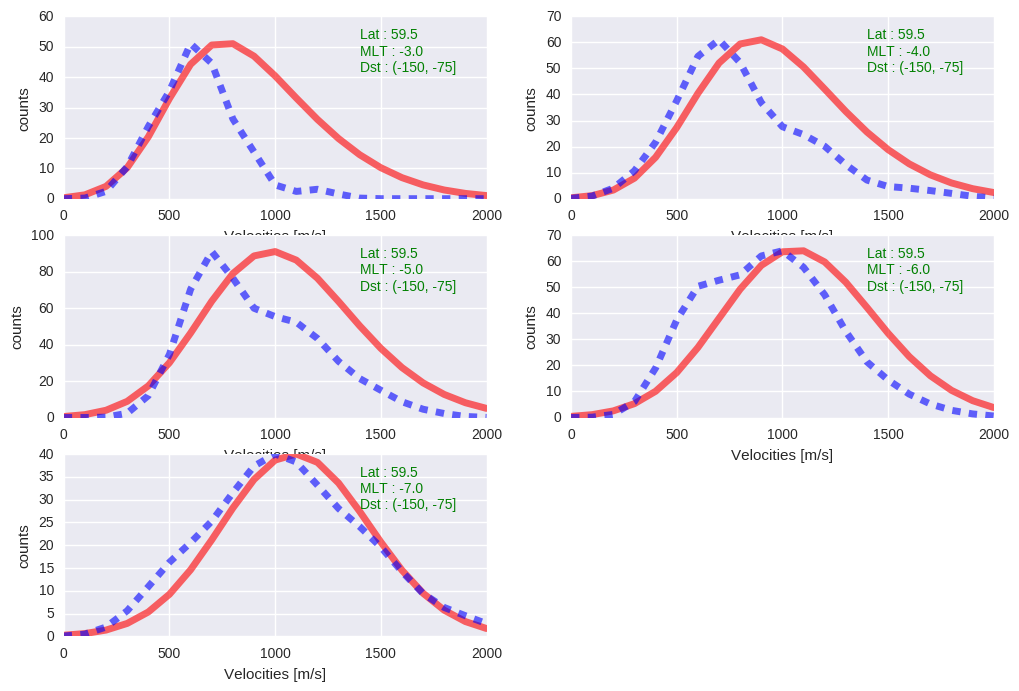

In [31]:
# Make a few plots of the fitting to get an estimate of how things are!
# Our velocities range from 0 to 2000 m/s
velsArr = numpy.arange(0.,2100.,100.)
velsNormArr = velsArr/2000.
selMLAT = 59.5#59.5#
selNormMLT = -3.#-3.#
selDstBin = "(-150, -75]"
selFitDF = fitSgDF[ (fitSgDF["dst_bin"] == selDstBin) &\
                (fitSgDF["mlat"] == selMLAT) ]
selVelDF = velGmagDF[ (velGmagDF["dst_bin"] == selDstBin) & \
                  (velGmagDF["MLAT"] == selMLAT) ]
# get dst mean for the selected bin
dstMeanValCurrBin = velGmagDF[ (velGmagDF["dst_bin"] == selDstBin)\
                      ]["dst_index"].unique()[0]
f = plt.figure(figsize=(12, 8))
axArr = []
axArr.append( f.add_subplot(3,2,1) )
axArr.append( f.add_subplot(3,2,2) )
axArr.append( f.add_subplot(3,2,3) ) 
axArr.append( f.add_subplot(3,2,4) )
axArr.append( f.add_subplot(3,2,5) )
for ind, currNormMLT in enumerate( numpy.sort( selFitDF["norm_mlt"].unique() )[::-1] ):
    shape = selFitDF[ selFitDF["norm_mlt"] == currNormMLT ]["pred_shape"].tolist()[0]
    loc = selFitDF[ selFitDF["norm_mlt"] == currNormMLT ]["pred_loc"].tolist()[0]
    scale = selFitDF[ selFitDF["norm_mlt"] == currNormMLT ]["pred_scale"].tolist()[0]
    subVelDF = selVelDF[ selVelDF["normMLT"] == currNormMLT ]
    velScale = subVelDF["vSaps"].value_counts(bins=velsArr[::2]).max()
#     print currNormMLT, shape, loc, scale
    pdf_fitted = scipy.stats.skewnorm.pdf(velsNormArr, shape, loc, scale)
#     print pdf_fitted
    velKernel = scipy.stats.gaussian_kde( subVelDF["vSaps"], bw_method="scott" )
    pdf_adjusted = pdf_fitted/max(pdf_fitted) * velScale
    kernel_adjusted = (velKernel.pdf( velsArr )/max(velKernel.pdf( velsArr ))) * velScale
    axArr[ind].plot(velsArr, pdf_adjusted, 'r-', lw=5, alpha=0.6)
    axArr[ind].plot(velsArr, kernel_adjusted, 'b--', lw=5, alpha=0.6)
    axArr[ind].set_xlabel("Velocities [m/s]")
    axArr[ind].set_ylabel("counts")
    printText = "Lat : " + str(selMLAT) +\
                "\n" + "MLT : " + str(currNormMLT) +\
                "\n" + "Dst : " + selDstBin
    axArr[ind].text(0.7, 0.7,  printText,
            transform=axArr[ind].transAxes,
            color='green', fontsize=10)
#     subVelDF["vSaps"].hist(ax=axArr[ind])
    axArr[ind].set_xlim( [0,2000] )
# plt.savefig("../figs/skewed-gaussian-fit-test.pdf",bbox_inches='tight')